In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from google.colab import files
import time

##Algoritmo RWMH para simular de la distribución Gama(5,1)

In [ ]:
def RWMH_gama51(p_ini, sigma, N):   #RWMH para simular de la distribución gamma(5,1)
  rechazos=0     #vector de muestras
  muestra=p_ini        #primera posición, nuestro punto inicial
  for i in range(1, N):           
    propuesta=p_ini+np.random.normal(0, sigma, p_ini.shape[1])    #el valor propuesto 
    razon = min((propuesta/p_ini)**4*np.exp(p_ini-propuesta),1)
    if random.uniform(0, 1) < razon and propuesta>0:
      actual=propuesta
      p_ini=propuesta
      
    else:
      actual=p_ini
      rechazos=rechazos+1
    muestra=np.r_[muestra,actual] #uno es el punto inicial y en la ultima posicion esta el porcentaje
  return(muestra, rechazos)    


In [ ]:
np.random.seed(0)
random.seed(0)
t0 = time.time()
simulacion=RWMH_gama51(np.array([[500]]),5,100000)  #generamos las simulaciones
t1 = time.time()
print("--- %s segundos ---" % (t1- t0))

--- 10.535802125930786 segundos ---


##Tasa de aceptación de la simulación

In [ ]:
cadena_bruta= simulacion[0]
tasa_rechazo= simulacion[1]/(cadena_bruta.shape[0]-1) 
tasa_aceptacion=1-tasa_rechazo
tasa_aceptacion  #porcentaje de estados aceptados

0.4402744027440274

## Burnin de manera gráfica

In [ ]:
def log_densidades_gamma_r(muest):    #log probabilidades
  return(np.log(1/24)+4*np.log(muest)-muest)

vector_verosim2 = np.zeros(400)
for i in range(0,400):
  vector_verosim2[i]=log_densidades_gamma_r(cadena_bruta[i])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

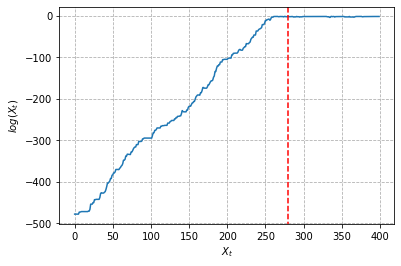

In [ ]:
burnin=280
plt.grid(linestyle='dashed')
plt.plot(vector_verosim2)
plt.ylabel('$log(X_{t})$')
plt.xlabel('$X_{t}$')
plt.axvline(burnin,-100,100,  color="red",  linestyle='dashed')
#plt.savefig("burnrwmh1.png",bbox_inches='tight',dpi=300)
#files.download("burnrwmh1.png")

##Burnin con distancias de Hellinger 

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("LaplacesDemon") #Cargamos la paqueteria 
library("LaplacesDemon")


In [ ]:
%R -i cadena_bruta #pasamos la cadena a R


In [ ]:
%%R

burn1<-BMK.Diagnostic(cadena_bruta, 200) #hacemos  200 subconjuntos
burnin_DH=as.numeric(c(0,colnames(burn1))[which.max(c(0,which(burn1>.5)))])
#diferencia mayor a 0.5
burnin_DH    #burnin propuesto con distancias de Hellinger


[1] 500


utilizaremos el burnin obtenido del método grafico 

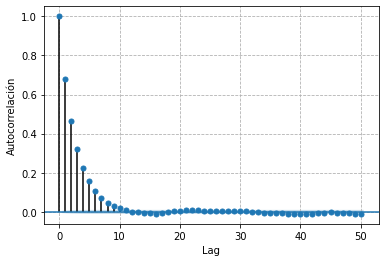

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cadena_sb=cadena_bruta[279:99999]   #quitamos las primeras 280 muestras
fig=plot_acf(cadena_sb, lags=50,alpha=0.05)  #autocorrelaciones 
plt.grid(linestyle='dashed')
plt.title("")
plt.ylabel('Autocorrelación')
plt.xlabel('Lag')
pyplot.show()
fig.savefig("autocor_1.png",bbox_inches='tight',dpi=300)
files.download("autocor_1.png") 

##Lag con IAT

In [ ]:
%%R
install.packages("Rtwalk")
library("Rtwalk")


In [ ]:
%R -i cadena_sb
%R iat1=IAT(cadena_sb)
%R  iat1

array([5.25739801])

In [ ]:
lag = %R iat1
lag= math.ceil(lag) #redondeamos hacia arriba
lag

6

In [ ]:
cadena_sl= cadena_sb[np.arange(0,len(cadena_sb),lag)]  #cadena sin lag


##Muestra total

In [ ]:
len(cadena_sl)

16620

##Densidad

Text(0.5, 0, '$X_{t}$')

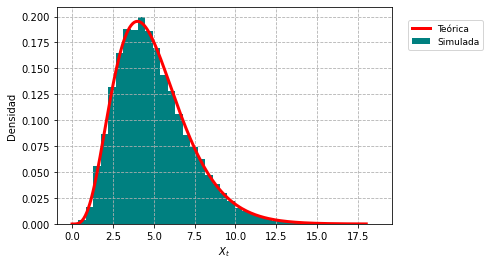

In [ ]:

x=np.linspace(0,18,200)
x_pdf=ss.gamma.pdf(x,a=5,scale=1)    #parametrizada, alfa = 5, betta=10
plt.plot(x,x_pdf, color="red",  linewidth=3)

plt.hist(cadena_sl, bins = int(40), density=True, color='teal')
#plt.title(" ")
plt.grid(linestyle='dashed')
plt.legend(('Teórica', 'Simulada'), bbox_to_anchor=(1.05,0.8), loc=3, borderaxespad=0, prop={'size':9})
plt.ylabel('Densidad')
plt.xlabel('$X_{t}$')

#plt.savefig("densidadgama1.png",bbox_inches='tight',dpi=300)
#files.download("densidadgama1.png")